In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [28]:
def load_and_transform_data(file_path):
    """
    Load the Excel file and transform data to have villas as rows and features as columns
    """
    # Read the Excel file
    raw_data = pd.read_excel(file_path)
    
    # Get feature names from the first column
    features = raw_data.iloc[:, 0].tolist()
    
    # Create an empty dataframe to store the transformed data
    transformed_data = pd.DataFrame()
    
    # For each villa column, create a row with all features
    for i in range(1, raw_data.shape[1]):
        villa_name = raw_data.columns[i]
        villa_values = raw_data.iloc[:, i].tolist()
        
        # Create a dictionary with features as keys and values for this villa
        villa_dict = {features[j]: villa_values[j] for j in range(len(features))}
        villa_dict['Villa'] = villa_name
        
        # Append to the dataframe
        transformed_data = pd.concat([transformed_data, pd.DataFrame([villa_dict])], 
                                    ignore_index=True)
    
    return transformed_data

In [29]:
def explore_data_distribution(data, numerical_cols, title=""):
    """
    Explore the distribution of numerical features and test for normality
    """
    print(f"\n--- Distribution Analysis for {title} ---")
    
    # Create histograms with KDE and QQ plots for each feature
    for i, col in enumerate(numerical_cols):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Histogram with KDE
        sns.histplot(data[col], kde=True, ax=ax1)
        ax1.set_title(f'Distribution of {col}')
        
        # QQ plot to check for normality
        stats.probplot(data[col], dist="norm", plot=ax2)
        ax2.set_title(f'Q-Q Plot for {col}')
        
        # Perform Shapiro-Wilk test for normality
        stat, p = stats.shapiro(data[col])
        
        plt.suptitle(f"{title} - {col} (Shapiro-Wilk p-value: {p:.4f})")
        plt.tight_layout()
        plt.show()
        
        print(f"{col}: Shapiro-Wilk p-value = {p:.4f} {'(Normal)' if p > 0.05 else '(Not Normal)'}")

In [30]:
def select_important_features(X_train, y_train, numerical_cols, threshold=0.05):
    """
    Select important features using RandomForest feature importance
    """
    # Train a RandomForest model
    base_model = RandomForestRegressor(n_estimators=100, random_state=42)
    base_model.fit(X_train, y_train)
    
    # Get feature importances
    importances = base_model.feature_importances_
    
    # Create a DataFrame with features and their importances
    feature_importance = pd.DataFrame({
        'Feature': numerical_cols,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Select features with importance above threshold
    important_features = feature_importance[feature_importance['Importance'] > threshold]['Feature'].tolist()
    
    print(f"\n--- Feature Importance ---")
    print(feature_importance)
    print(f"\nSelected {len(important_features)} important features out of {len(numerical_cols)}")
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return important_features

In [31]:
def augment_data(data, target_column, numerical_cols, important_features, num_samples=100):
    """
    Generate augmented data samples with reduced noise and focus on important features
    """
    augmented_data = pd.DataFrame()
    
    # Create a model to predict prices based on original data
    X_orig = data[numerical_cols]
    y_orig = data[target_column]
    
    # Use a more regularized model for prediction
    base_model = RandomForestRegressor(
        n_estimators=100, 
        max_depth=10,  # Limit depth to prevent overfitting
        min_samples_split=5,  # Require more samples to split
        random_state=42
    )
    base_model.fit(X_orig, y_orig)
    
    # Generate augmented samples
    for i in range(num_samples):
        # Randomly select a sample from original data
        sample_idx = np.random.randint(0, len(data))
        sample = data.iloc[[sample_idx]].copy()
        
        # Add noise to features - only modify important features with reduced noise
        for col in numerical_cols:
            # Apply much lower noise levels
            if col in important_features:
                if "area" in col.lower():
                    noise_level = 0.03  # 3% noise for areas (reduced from 8%)
                elif "Number of" in col:
                    noise_level = 0.05  # 5% noise for counts (reduced from 15%)
                elif "Distance" in col:
                    noise_level = 0.04  # 4% noise for distance (reduced from 12%)
                elif "Snow" in col:
                    noise_level = 0.02  # 2% noise for snow zone (reduced from 5%)
                else:
                    noise_level = 0.03  # 3% default noise (reduced from 10%)
                    
                # Generate noise
                std_dev = data[col].std()
                noise = np.random.normal(0, std_dev * noise_level)
                
                # Add noise
                sample[col] = sample[col] + noise
                
                # Handle special cases
                if "Number of" in col:
                    # For count features, round to nearest integer and ensure non-negative
                    sample[col] = round(max(0, sample[col].values[0]))
        
        # Predict new price based on modified features
        new_price = base_model.predict(sample[numerical_cols])[0]
        
        # Add small random noise to the price (1% variation, reduced from 3%)
        price_noise = np.random.normal(0, new_price * 0.01)
        sample[target_column] = max(0, new_price + price_noise)
        
        # Rename villa
        sample['Villa'] = f'Aug_Villa_{i+1}'
        
        # Add to augmented dataset
        augmented_data = pd.concat([augmented_data, sample], ignore_index=True)
    
    return augmented_data

In [32]:
def evaluate_model(X_train, y_train, X_test, y_test, model_name="Random Forest"):
    """
    Train a random forest regressor with regularization and evaluate its performance
    """
    # Create a more regularized RandomForest model
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,  # Limit depth to prevent overfitting
        min_samples_split=5,  # Require more samples to split
        min_samples_leaf=2,  # Require more samples in a leaf
        max_features='sqrt',  # Use sqrt of total features at each split
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics for training data
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    train_r2 = r2_score(y_train, y_pred_train)
    
    # Calculate metrics for test data
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Cross-validation
    kf = KFold(n_splits=min(5, len(X_train)), shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, 
                               cv=kf, 
                               scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    return {
        'model': model,
        'train_mae': train_mae,
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'cv_rmse': cv_rmse,
        'y_pred_test': y_pred_test
    }


In [33]:
def compare_feature_distributions(original_data, augmented_data, numerical_cols):
    """
    Compare the distributions of each feature in the original and augmented datasets
    """
    n_cols = len(numerical_cols)
    n_rows = (n_cols + 1) // 2  # Calculate number of rows needed
    
    plt.figure(figsize=(15, 4 * n_rows))
    
    for i, col in enumerate(numerical_cols):
        plt.subplot(n_rows, 2, i+1)
        
        # Plot histograms for original and augmented data
        sns.histplot(original_data[col], alpha=0.5, label='Original', kde=True)
        sns.histplot(augmented_data[col], alpha=0.5, label='Augmented', kde=True)
        
        plt.title(f'Distribution of {col}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [34]:
def test_multiple_sample_sizes(data, target_column, numerical_cols, sample_sizes):
    """
    Test different augmentation sample sizes and evaluate model performance
    With improved feature selection and reduced noise
    """
    results = {}
    
    # Split original data into train and test sets FIRST
    X_orig = data[numerical_cols]
    y_orig = data[target_column]
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        X_orig, y_orig, test_size=0.3, random_state=42)
    
    # Reconstruct the training dataframe with all columns
    train_indices = X_train_orig.index
    train_data = data.iloc[train_indices].copy().reset_index(drop=True)
    
    # Select important features for focused augmentation
    important_features = select_important_features(X_train_orig, y_train_orig, numerical_cols)
    
    # Baseline model with original data only
    original_results = evaluate_model(X_train_orig, y_train_orig, X_test_orig, y_test_orig)
    results['original'] = {
        'train_rmse': original_results['train_rmse'],
        'test_rmse': original_results['test_rmse'],
        'train_r2': original_results['train_r2'],
        'test_r2': original_results['test_r2'],
        'cv_rmse': original_results['cv_rmse']
    }
    
    for size in sample_sizes:
        print(f"\nTesting with {size} augmented samples...")
        
        # Generate augmented data ONLY from training data with improved augmentation
        augmented_data = augment_data(train_data, target_column, numerical_cols, 
                                     important_features, num_samples=size)
        
        # Combine original training data and augmented data
        combined_train_data = pd.concat([train_data, augmented_data], ignore_index=True)
        
        # Extract features and target from combined training data
        X_train_combined = combined_train_data[numerical_cols]
        y_train_combined = combined_train_data[target_column]
        
        # Evaluate model trained on combined data (but test on original test set)
        combined_results = evaluate_model(X_train_combined, y_train_combined, X_test_orig, y_test_orig)
        
        results[f'augmented_{size}'] = {
            'train_rmse': combined_results['train_rmse'],
            'test_rmse': combined_results['test_rmse'],
            'train_r2': combined_results['train_r2'],
            'test_r2': combined_results['test_r2'],
            'cv_rmse': combined_results['cv_rmse']
        }
        
        # For the largest size, also do a detailed feature distribution comparison
        if size == max(sample_sizes):
            # Compare distributions
            compare_feature_distributions(train_data, augmented_data, numerical_cols)
            
            # Evaluate the quality of the augmented data
            validate_augmented_data_quality(train_data, augmented_data, numerical_cols)
    
    return results, original_results, combined_results

In [35]:
def plot_sample_size_results(results, sample_sizes):
    """
    Plot the model performance metrics for different sample sizes
    """
    sizes = ['original'] + [f'augmented_{size}' for size in sample_sizes]
    
    # Prepare data for plotting
    test_rmse = [results[size]['test_rmse'] for size in sizes]
    test_r2 = [results[size]['test_r2'] for size in sizes]
    cv_rmse = [results[size]['cv_rmse'] for size in sizes]
    
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot RMSE values
    x = np.arange(len(sizes))
    width = 0.35
    
    ax1.bar(x, test_rmse, width, label='Test RMSE')
    ax1.bar(x + width, cv_rmse, width, label='Cross-Val RMSE')
    
    ax1.set_xlabel('Sample Size')
    ax1.set_ylabel('RMSE')
    ax1.set_title('RMSE by Sample Size')
    ax1.set_xticks(x + width / 2)
    ax1.set_xticklabels([s.replace('augmented_', '') for s in sizes])
    ax1.legend()
    
    # Plot R² values
    ax2.plot(x, test_r2, 'o-', label='Test R²')
    ax2.set_xlabel('Sample Size')
    ax2.set_ylabel('R² Score')
    ax2.set_title('R² Score by Sample Size')
    ax2.set_xticks(x)
    ax2.set_xticklabels([s.replace('augmented_', '') for s in sizes])
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [36]:
def validate_augmented_data_quality(original_data, augmented_data, numerical_cols):
    """
    Validate the quality of augmented data by comparing distributions 
    and checking for unrealistic values
    """
    print("\n--- Augmented Data Quality Validation ---")
    
    # 1. Statistical comparison of distributions (Kolmogorov-Smirnov test)
    print("\nKolmogorov-Smirnov Test (distributions similarity):")
    for col in numerical_cols:
        stat, p = stats.ks_2samp(original_data[col], augmented_data[col])
        similarity = "Similar" if p > 0.05 else "Different"
        print(f"{col}: p-value = {p:.4f} ({similarity})")
    
    # 2. Check for out-of-range values
    print("\nRange Comparison (min-max):")
    for col in numerical_cols:
        orig_min, orig_max = original_data[col].min(), original_data[col].max()
        aug_min, aug_max = augmented_data[col].min(), augmented_data[col].max()
        
        # Calculate percentage of values outside the original range
        outside_range = ((augmented_data[col] < orig_min) | (augmented_data[col] > orig_max)).mean() * 100
        
        print(f"{col}:")
        print(f"  Original range: [{orig_min:.2f}, {orig_max:.2f}]")
        print(f"  Augmented range: [{aug_min:.2f}, {aug_max:.2f}]")
        print(f"  Values outside original range: {outside_range:.2f}%")
    
    # 3. Compare means and standard deviations
    print("\nMean and Standard Deviation Comparison:")
    for col in numerical_cols:
        orig_mean, orig_std = original_data[col].mean(), original_data[col].std()
        aug_mean, aug_std = augmented_data[col].mean(), augmented_data[col].std()
        
        mean_diff_pct = abs(orig_mean - aug_mean) / orig_mean * 100 if orig_mean != 0 else 0
        std_diff_pct = abs(orig_std - aug_std) / orig_std * 100 if orig_std != 0 else 0
        
        print(f"{col}:")
        print(f"  Original: mean={orig_mean:.2f}, std={orig_std:.2f}")
        print(f"  Augmented: mean={aug_mean:.2f}, std={aug_std:.2f}")
        print(f"  Difference: mean={mean_diff_pct:.2f}%, std={std_diff_pct:.2f}%")

In [37]:
def plot_comparison_results(original_results, combined_results, y_test_orig):
    """
    Plot comparison of model predictions
    """
    plt.figure(figsize=(14, 6))
    
    # Original model results
    plt.subplot(1, 2, 1)
    plt.scatter(y_test_orig, original_results['y_pred_test'])
    plt.plot([y_test_orig.min(), y_test_orig.max()], 
             [y_test_orig.min(), y_test_orig.max()], 'k--')
    plt.title('Original Model')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    
    # Augmented model results
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_orig, combined_results['y_pred_test'])
    plt.plot([y_test_orig.min(), y_test_orig.max()], 
             [y_test_orig.min(), y_test_orig.max()], 'k--')
    plt.title('Augmented Model')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    
    plt.tight_layout(pad=3.0)
    plt.show()



Loading and transforming data...
Loaded 22 villas with 13 features
Using 11 numerical features: ['Wall area (m2)', 'Inner walls area (m2)', 'Roof area (m2)', 'Floor area 2nd floor (m2)', 'Distance Location (km)', 'Number of windows std size', 'Number of windows >18 height', 'Number of sliding doors', 'Number of window doors', 'Number of doors', 'Snow zone']

--- Distribution Analysis for Original Data ---


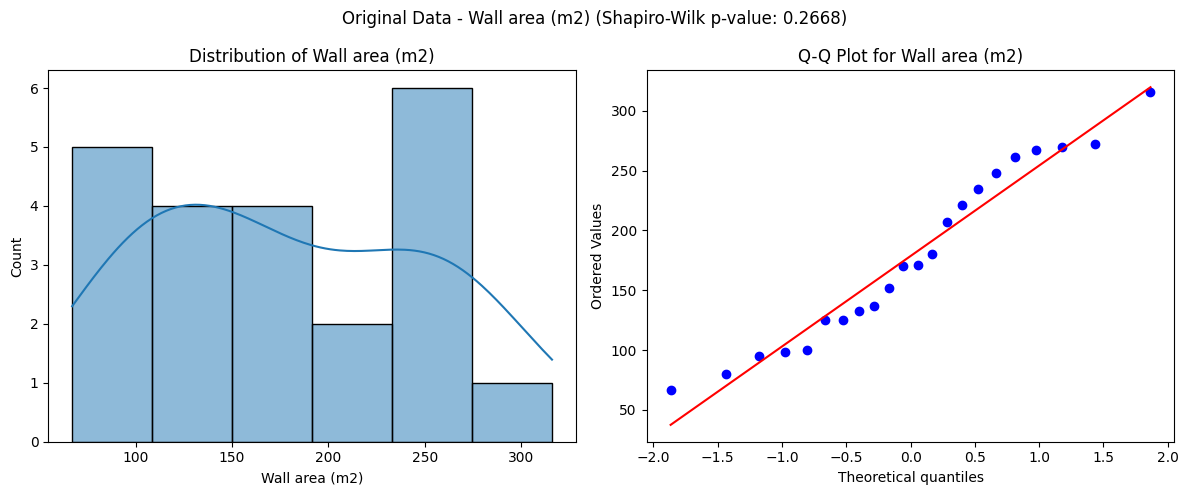

Wall area (m2): Shapiro-Wilk p-value = 0.2668 (Normal)


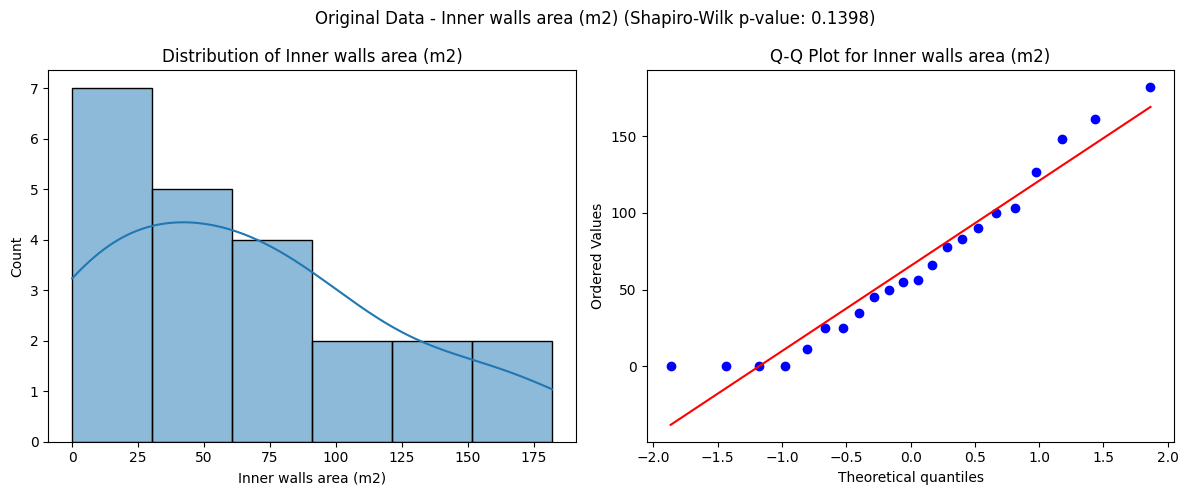

Inner walls area (m2): Shapiro-Wilk p-value = 0.1398 (Normal)


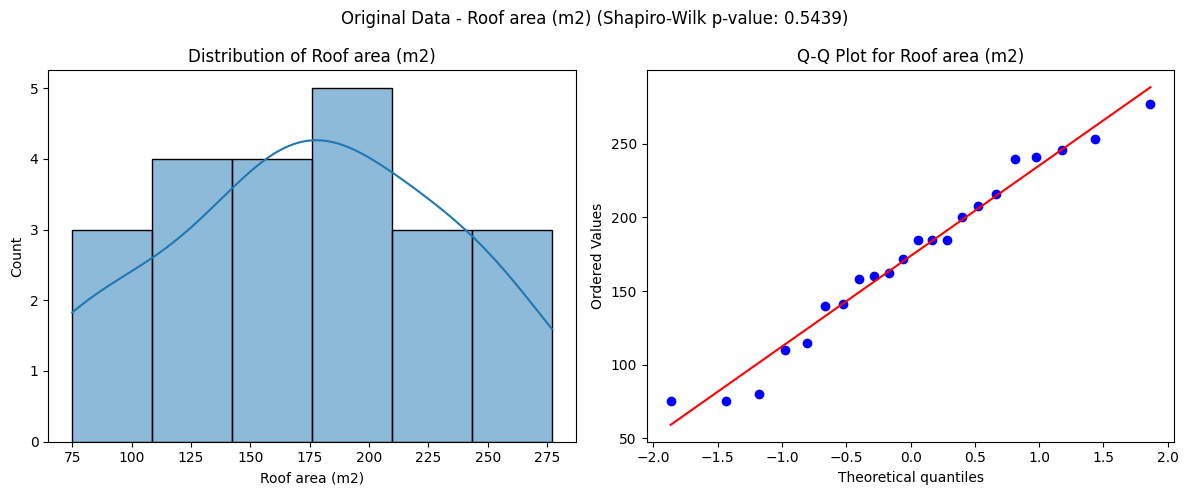

Roof area (m2): Shapiro-Wilk p-value = 0.5439 (Normal)


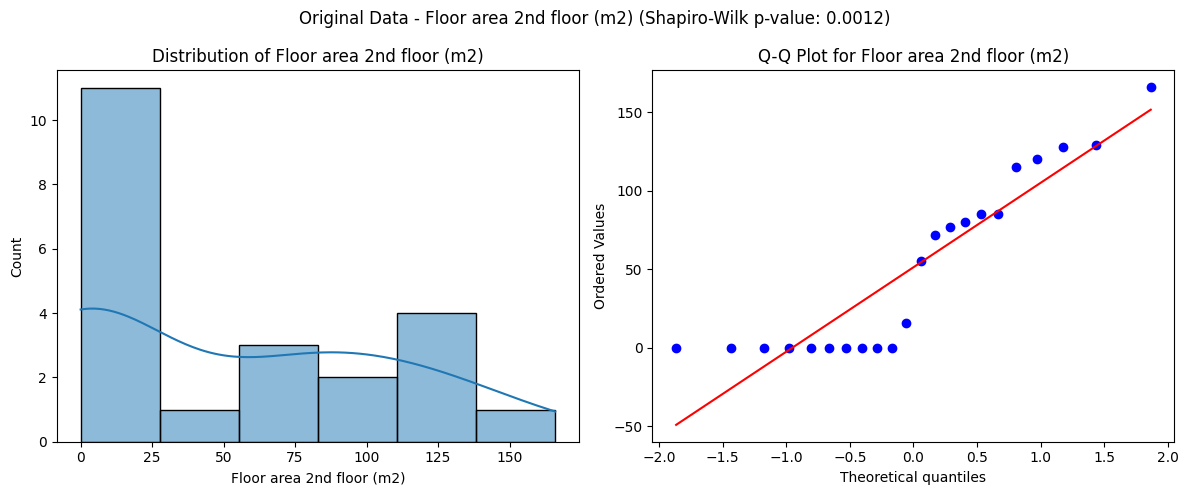

Floor area 2nd floor (m2): Shapiro-Wilk p-value = 0.0012 (Not Normal)


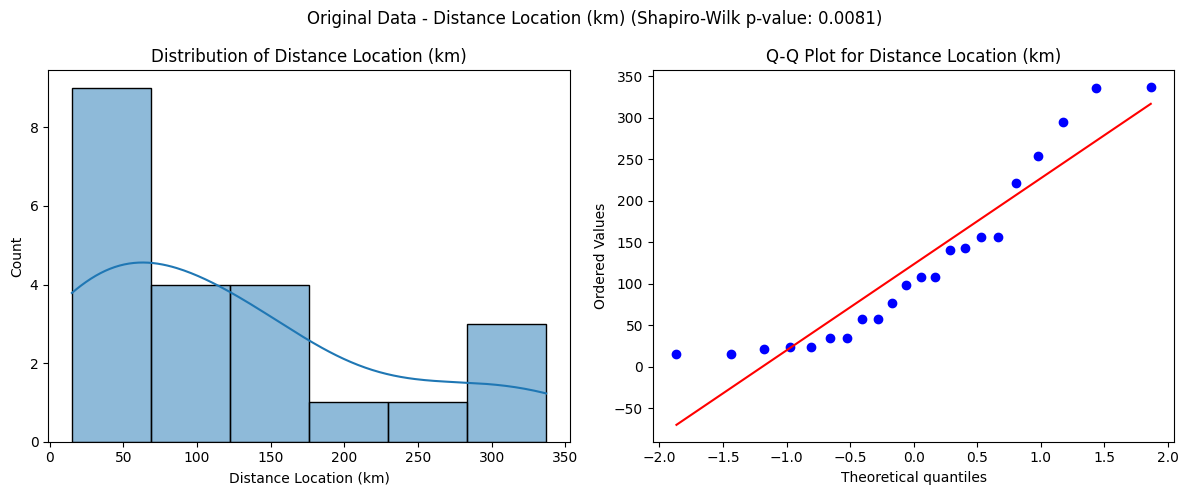

Distance Location (km): Shapiro-Wilk p-value = 0.0081 (Not Normal)


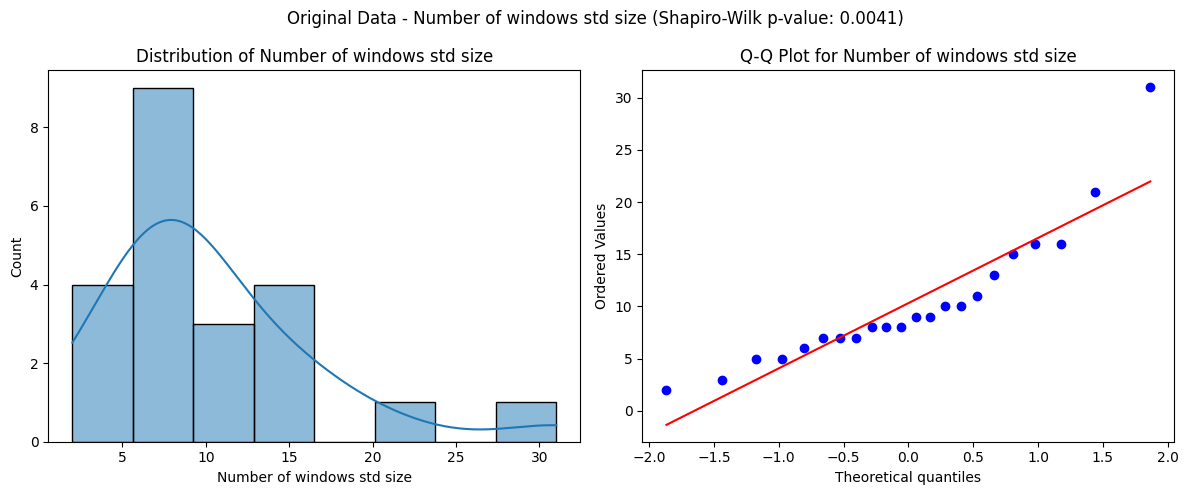

Number of windows std size: Shapiro-Wilk p-value = 0.0041 (Not Normal)


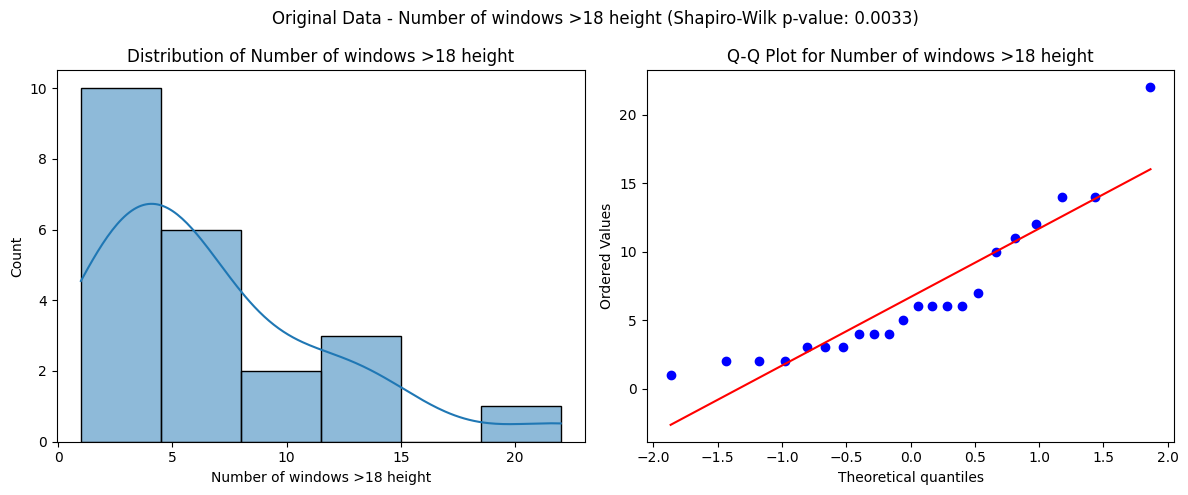

Number of windows >18 height: Shapiro-Wilk p-value = 0.0033 (Not Normal)


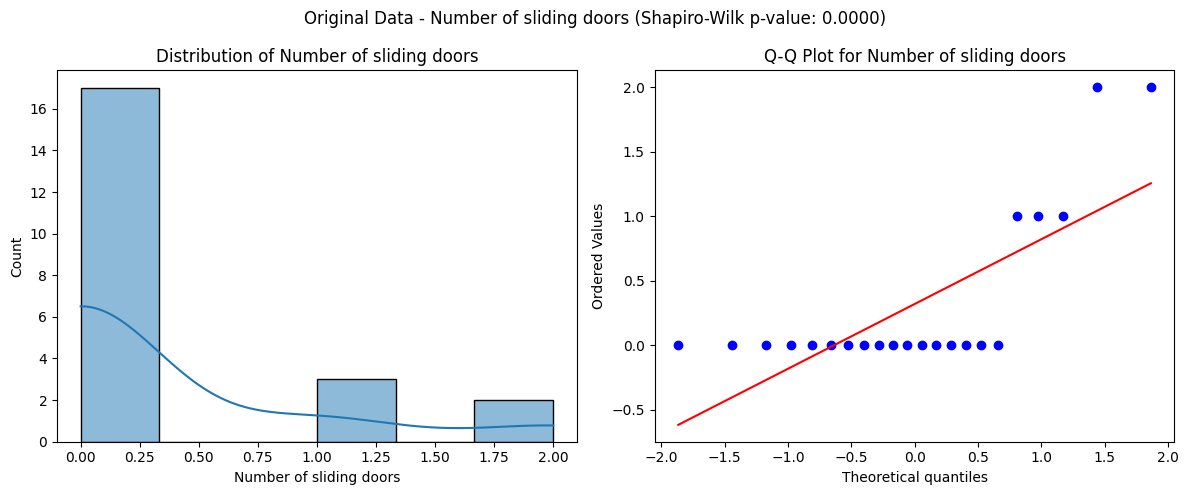

Number of sliding doors: Shapiro-Wilk p-value = 0.0000 (Not Normal)


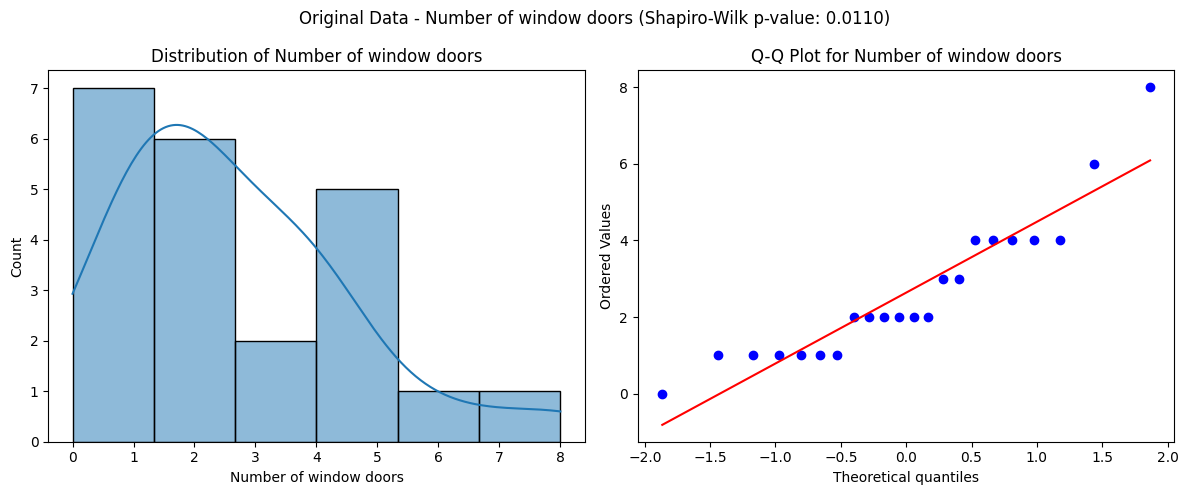

Number of window doors: Shapiro-Wilk p-value = 0.0110 (Not Normal)


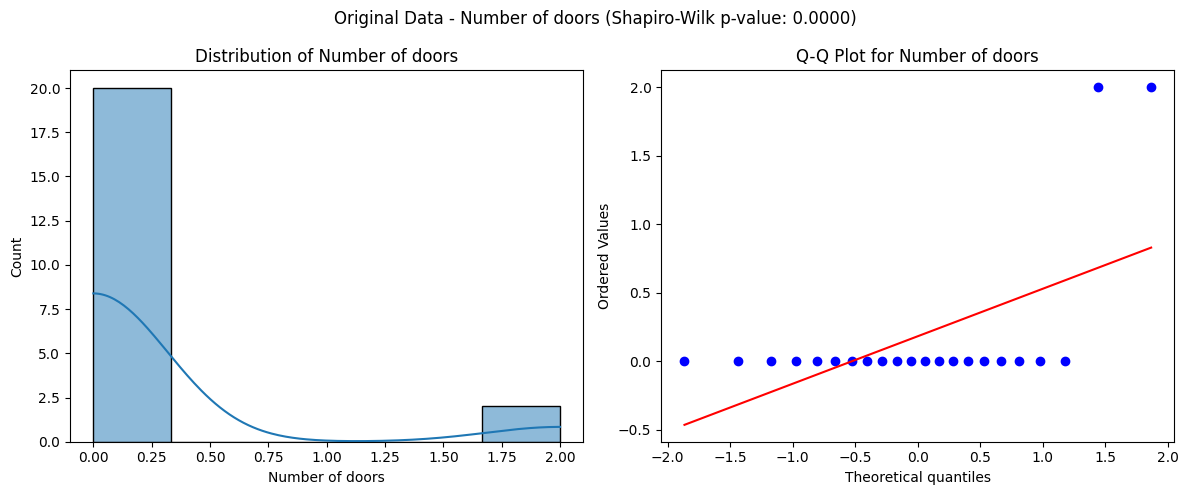

Number of doors: Shapiro-Wilk p-value = 0.0000 (Not Normal)


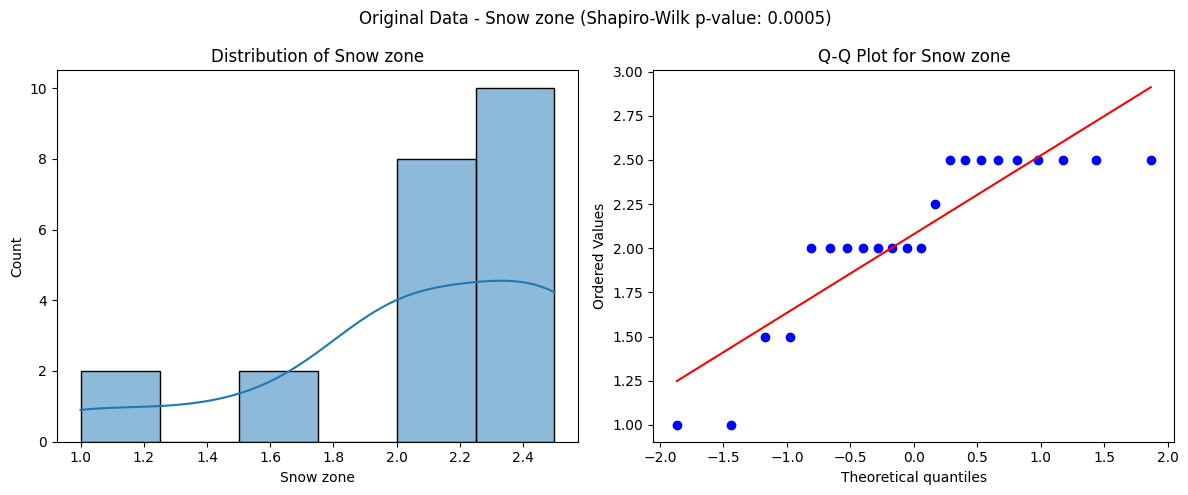

Snow zone: Shapiro-Wilk p-value = 0.0005 (Not Normal)

--- Feature Importance ---
                         Feature  Importance
0                 Wall area (m2)    0.548455
3      Floor area 2nd floor (m2)    0.151815
6   Number of windows >18 height    0.126619
5     Number of windows std size    0.060091
2                 Roof area (m2)    0.029862
10                     Snow zone    0.022941
4         Distance Location (km)    0.022370
1          Inner walls area (m2)    0.020641
8         Number of window doors    0.011432
7        Number of sliding doors    0.005739
9                Number of doors    0.000033

Selected 4 important features out of 11


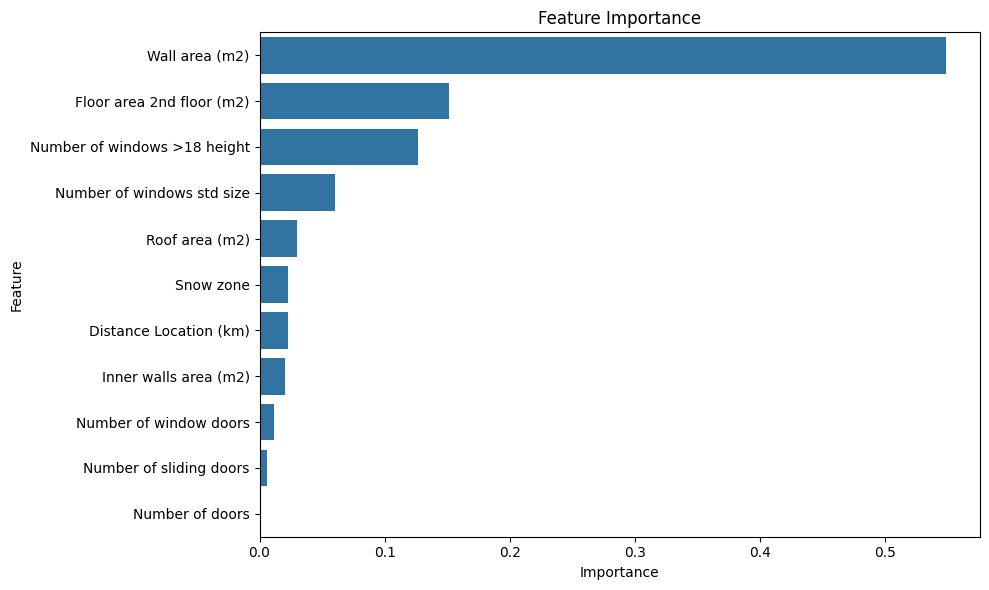


Testing with 100 augmented samples...

Testing with 200 augmented samples...

Testing with 500 augmented samples...

Testing with 1000 augmented samples...


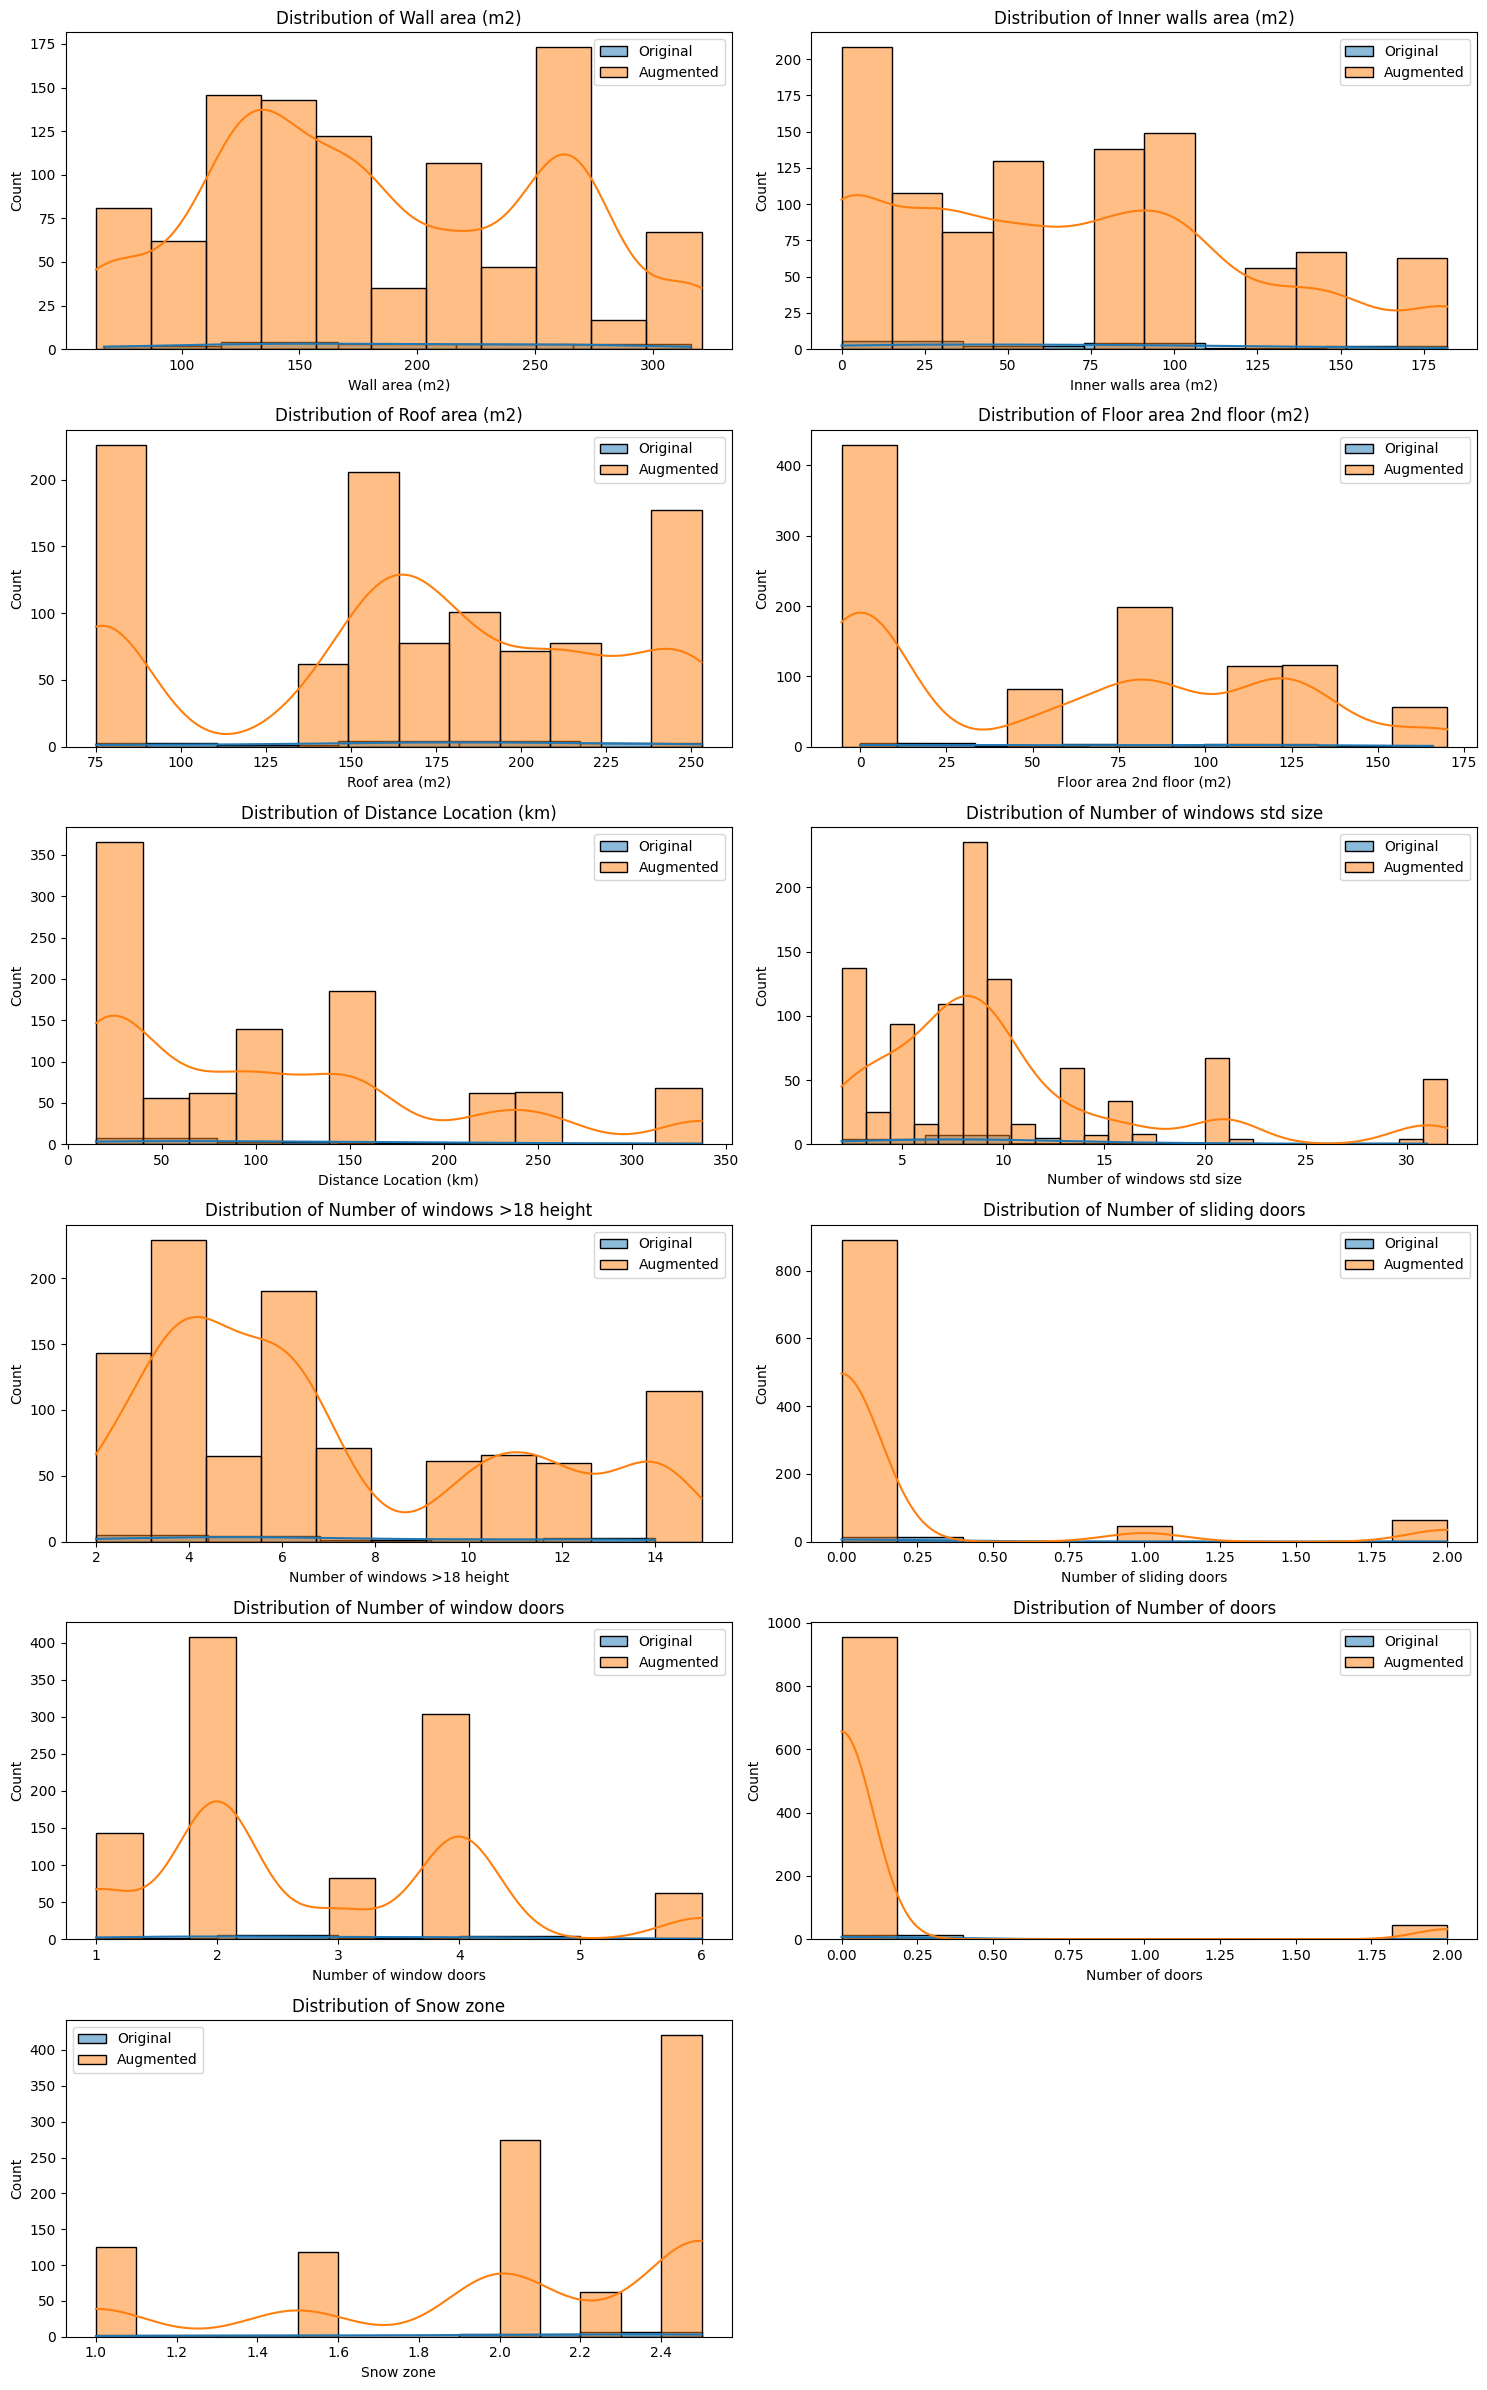


--- Augmented Data Quality Validation ---

Kolmogorov-Smirnov Test (distributions similarity):
Wall area (m2): p-value = 0.9998 (Similar)
Inner walls area (m2): p-value = 1.0000 (Similar)
Roof area (m2): p-value = 1.0000 (Similar)
Floor area 2nd floor (m2): p-value = 0.5248 (Similar)
Distance Location (km): p-value = 1.0000 (Similar)
Number of windows std size: p-value = 1.0000 (Similar)
Number of windows >18 height: p-value = 1.0000 (Similar)
Number of sliding doors: p-value = 1.0000 (Similar)
Number of window doors: p-value = 1.0000 (Similar)
Number of doors: p-value = 1.0000 (Similar)
Snow zone: p-value = 1.0000 (Similar)

Range Comparison (min-max):
Wall area (m2):
  Original range: [67.00, 316.00]
  Augmented range: [63.68, 320.64]
  Values outside original range: 7.20%
Inner walls area (m2):
  Original range: [0.00, 182.00]
  Augmented range: [0.00, 182.00]
  Values outside original range: 0.00%
Roof area (m2):
  Original range: [75.00, 253.00]
  Augmented range: [75.00, 253.00]

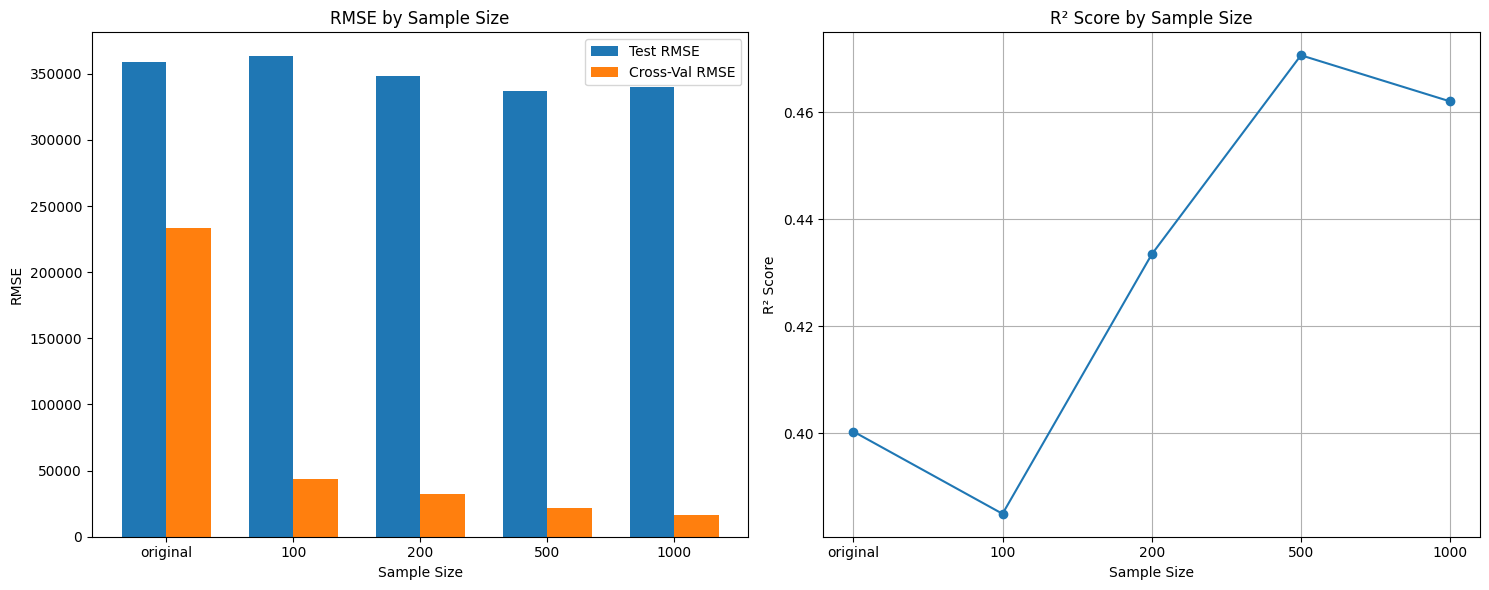

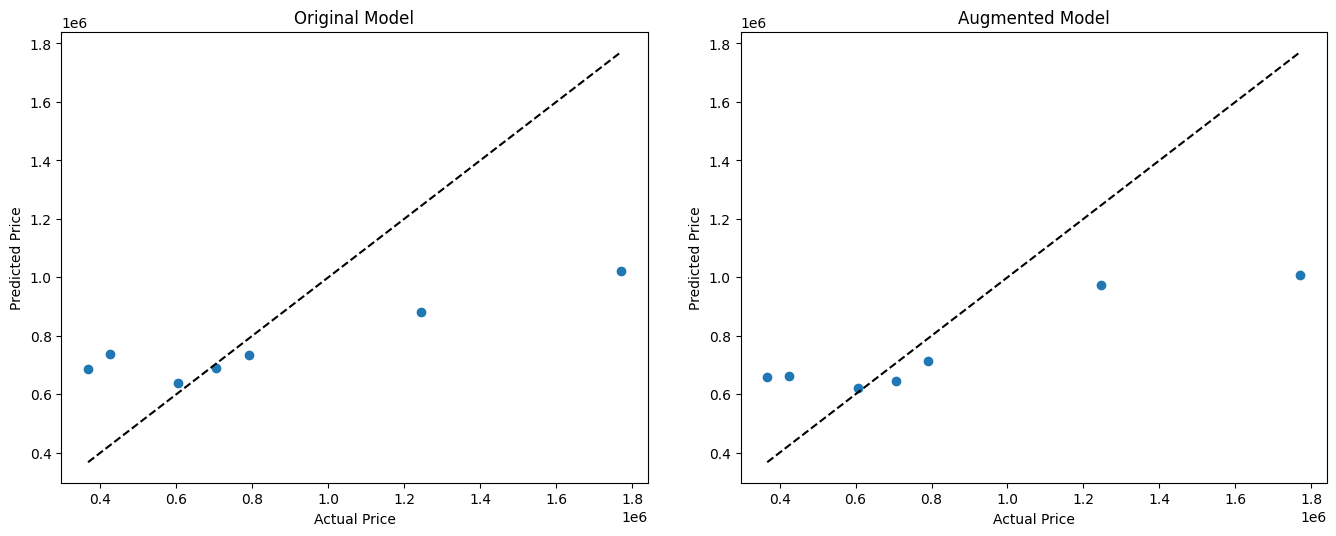


--- Final Model Comparison ---
Original Model:
  Training RMSE: 140925.21
  Test RMSE: 358563.37
  Training R²: 0.8068
  Test R²: 0.4003

Augmented Model (with 1000 samples):
  Training RMSE: 11983.83
  Test RMSE: 339615.16
  Training R²: 0.9977
  Test R²: 0.4620

Improvement with Augmented Data:
  RMSE Improvement: 5.28%
  R² Improvement: 15.41%


In [39]:
if __name__ == "__main__":
    # Set the path to your Excel file
    file_path = "C:\\Users\\valer\\Downloads\\Data_set (1).xlsx"  # Update with your actual file path
    
    # Load and transform the data
    print("Loading and transforming data...")
    data = load_and_transform_data(file_path)
    print(f"Loaded {len(data)} villas with {data.shape[1]} features")
    
    # Define target column and identify numerical features
    target_column = 'Price (SEK exkl tax)'
    numerical_cols = [col for col in data.columns 
                     if pd.api.types.is_numeric_dtype(data[col]) 
                     and col != target_column and col != 'Villa']
    
    print(f"Using {len(numerical_cols)} numerical features: {numerical_cols}")
    
    # Explore original data distribution
    explore_data_distribution(data, numerical_cols, "Original Data")
    
    # Test multiple sample sizes with improved augmentation
    # Using fewer samples to avoid overwhelming the model
    sample_sizes = [100, 200, 500, 1000]
    size_results, original_results, final_combined_results = test_multiple_sample_sizes(
        data, target_column, numerical_cols, sample_sizes)
    
    # Plot the results for different sample sizes
    plot_sample_size_results(size_results, sample_sizes)
    
    # Get the test data for plotting
    X_orig = data[numerical_cols]
    y_orig = data[target_column]
    _, X_test_orig, _, y_test_orig = train_test_split(
        X_orig, y_orig, test_size=0.3, random_state=42)
    
    # Plot comparison of original vs augmented model
    plot_comparison_results(original_results, final_combined_results, y_test_orig)
    
    # Print final comparison
    print("\n--- Final Model Comparison ---")
    print(f"Original Model:")
    print(f"  Training RMSE: {original_results['train_rmse']:.2f}")
    print(f"  Test RMSE: {original_results['test_rmse']:.2f}")
    print(f"  Training R²: {original_results['train_r2']:.4f}")
    print(f"  Test R²: {original_results['test_r2']:.4f}")
    
    print(f"\nAugmented Model (with {max(sample_sizes)} samples):")
    print(f"  Training RMSE: {final_combined_results['train_rmse']:.2f}")
    print(f"  Test RMSE: {final_combined_results['test_rmse']:.2f}")
    print(f"  Training R²: {final_combined_results['train_r2']:.4f}")
    print(f"  Test R²: {final_combined_results['test_r2']:.4f}")
    
    # Calculate improvement
    rmse_improvement = (original_results['test_rmse'] - final_combined_results['test_rmse']) / original_results['test_rmse'] * 100
    r2_improvement = (final_combined_results['test_r2'] - original_results['test_r2'])
    if original_results['test_r2'] != 0:
        r2_improvement = r2_improvement / abs(original_results['test_r2']) * 100
    
    print(f"\nImprovement with Augmented Data:")
    print(f"  RMSE Improvement: {rmse_improvement:.2f}%")
    print(f"  R² Improvement: {r2_improvement:.2f}%")